# Computer Vision - Classification Task

The following notebook was designed to train a model that was capable of distinguish between 13 classes of food:
0. pasta_with_pesto
1. pasta_with_tomato_sauce
2. pasta_with_meat_sauce
3. pasta_with_clams_and_mussels
4. pilaw_rice_with_peppers_and_peas
5. grilled_pork_cutlet
6. fish_cutlet
7. rabbit
8. seafood_salad
9. beans
10. basil_potatoes
11. salad
12. bread

The final architecture chosen was a resnet34-based model partially frozen with a 2-layer MLP ending in softmax.

## Settint up the Environment

Given the fact that the datasets across all variations were 400-1200 MB heavy they were first compressed, added to google drive and finally unzipped in the environment of google colab for better performances.

In [6]:
from google.colab import drive
from google.colab import files as colab_files

drive.mount('/content/drive')
!unzip -n -q "/content/drive/My Drive/Dataset_cv_train_cropped_augmented.zip" -d "./"
!unzip -n -q "/content/drive/My Drive/Dataset_cv_test.zip" -d "./"
# Remember to increment the model name
model_name = "iter8.pt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import torch
from PIL import Image
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

## The model

The final architecture is resnet34 based. Even though resnet50 is the current SotA, it is far too advanced for this task and tends to overfit quite easily the data provided, therefore resnet34 was chosen.

All layers of resnet-34 were frozen but the last one to provide useful features. On top of it a fully connect multi-layer perceptron was used to infere the actual classification task, completed with softmax to obtain "probabilistic"  interpretation of the output.

The optimal parameters found were:
* MLP_SIZE = 200
* DROPOUT = 0.3

In [8]:
RESNET_OUT = 512 # For resnet34
MLP_SIZE = 200 #@param
DROPOUT = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}

In [9]:
class Net(nn.Module):
  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device

    # Adding resnet
    resnet34 = models.resnet34(pretrained=True)
    # Removing last fully connected layer
    self.resnet = torch.nn.Sequential(*(list(resnet34.children())[:-1]))
    self.resnet = self.resnet.to(device)
    # Freezing all params but the last layer
    for param in self.resnet.parameters():
      param.requires_grad = False
    for param in self.resnet[7].parameters():
      param.requires_grad = True


    # initialize MLP feedforward
    self.w1 = torch.nn.Linear(RESNET_OUT, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 13, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    # Adding droput for regularization
    self.dropout = torch.nn.Dropout(DROPOUT)

  def forward(self, x):
    """
      Given the tensor-image returns the probabilities

      Arguments
      ---------
      x: Tensor of size (batch_size, 3, 224, 224) obtained from the image

      Returns
      -------
      out: A tensor of size (batch_size, 13), each row represents the probabilies

    """
    x = x.to(self.device)

    # Obtaining the features of the image
    h = self.resnet(x).squeeze()
    h = h.to(self.device)

    # Using the MLP on features
    out = self.mlp(h)

    return out

  def mlp(self, x):
    """
      This function performs the classification part of the net.
      It uses droput while training for regularization.

      Arguments
      ---------
      x: a tensor of size (batch_size, RESNET_OUT) of features from resnet

      Returns
      -------
      probs: the softmax after passing the input tensor through a 2
             layer MLP.
    """
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))




## Dataset

The dataset was retrieved from Google Images and iteration after iteration was enhanced, take a look at the report for better understanding.

The main folder structure is expected to be structured as follows:
```bash
/root_dir
--/pasta_with_pesto
----/image1.jpg
----/2.png
--/pasta_with_tomato_sauce
--/pasta_with_meat_sauce
--/pasta_with_clams_and_mussels
--/pilaw_rice_with_peppers_and_peas
--/grilled_pork_cutlet
--/fish_cutlet
--/rabbit
--/seafood_salad
--/beans
--/basil_potatoes
--/salad
--/bread
```


In [10]:
class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = []
        self.labels = []
        self.classes = []

        self.labelsDict = {
          "pasta_with_pesto": 0,
          "pasta_with_tomato_sauce": 1,
          "pasta_with_meat_sauce": 2,
          "pasta_with_clams_and_mussels": 3,
          "pilaw_rice_with_peppers_and_peas": 4,
          "grilled_pork_cutlet": 5,
          "fish_cutlet": 6,
          "rabbit": 7,
          "seafood_salad": 8,
          "beans": 9,
          "basil_potatoes": 10,
          "salad": 11,
          "bread": 12
        }

        # List all subfolders (classes) in the root directory
        self.classes = [folder for folder in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, folder))]

        # Iterate over each class folder
        for i, class_folder in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_folder)

            # List all image files in the class folder
            image_files = [file for file in os.listdir(class_path) if self.is_image_file(file)]

            # Store the image files and corresponding labels
            for image_file in image_files:
              image_path = os.path.join(self.root_dir, class_folder, image_file)
              self.image_files.append(image_path)
              self.labels.append(self.labelsDict[class_folder])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
          This function is used for querying the dataset

          Arguments
          ---------

          idx: The id of the element, must be in [0,self.__len__() - 1]

          Returns
          -------

          input_tensor: The tensor ready to be fed to resnet
          one_hot_vector: The one_hot_vector tensor representing the correct class
          image_path: The image path of the current element, useful for debugging
        """
        image_path = self.image_files[idx]
        label = self.labels[idx]


        image = Image.open(image_path).convert('RGB')

        # Each image has to be pre-processed before being fed to resnet
        # The following transform has the solely purpose of replicating such behaviour
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(image)

        # Returning a one-hot-vector corresponding to the class
        one_hot_vector = torch.eye(len(self.classes))[label]

        return input_tensor, one_hot_vector, image_path

    @staticmethod
    def is_image_file(filename):
        return any(filename.lower().endswith(extension) for extension in ['.jpg', '.jpeg', '.png'])

In [18]:
# Specify the ratio train/test

VALIDATION_RATIO = 0.2 #@param {type:"slider", min:0, max:0.5, step:0.01}
BATCH_SIZE = 20 # @param

In [19]:
train_dev_dataset = CustomDataset("./Dataset_cv_train_cropped_augmented")
test_dataset = CustomDataset("./Dataset_cv_test")

# Calculate the lengths of training and validation sets
num_samples = len(train_dev_dataset)
num_validation_samples = int(VALIDATION_RATIO * num_samples)
num_train_samples = num_samples - num_validation_samples

train_dataset, val_dataset = random_split(train_dev_dataset, [num_train_samples, num_validation_samples])

# Create data loaders for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Setting up for training

The following functions are used to respectively train and test the model. They are extremely generalized, taking into account any kind of arguments for flexibility.
The train functions returns the average loss, while the test funtion returns the accuracy over any dataset.

In [11]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    optimizer.zero_grad()
    images, labels, image_paths = batch

    out = model(images)
    labels = labels.to(device)
    if len(out.shape) == 1:
      out = out.unsqueeze(0)
    loss = criterion(out, labels)

    count += 1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

def test(model, dataloader):
  model.eval()
  right_predictions = 0
  count = 0

  for batch in dataloader:
    images, labels, image_paths = batch

    out = model(images)
    labels = labels.to(device)
    if len(out.shape) == 1:
      out = out.unsqueeze(0)

    for i in range(0, len(images)):
      pred = out[i]
      label = labels[i]
      pred_class = torch.argmax(pred)
      if label[pred_class] == 1:
        right_predictions += 1
      count += 1

  return right_predictions/count

## Training

The optimal parameters were found to be 8 epochs and a learning rate of 3e-5. The network overfit easily and has to be fine tuned carefully to avoid it.

The losses used were Means Squared Loss and Cross Entropy Loss. Both were effective, however Cross Entropy loss was more "gentle" with the convergence during training.

In [ ]:
EPOCHS = 8 # @param {type: "integer"}
LR = 3e-5 # @param ["3e-4", "1e-4", "5e-5", "2e-5", "3e-5"] {type:"raw"}

In [16]:
# move the input and model to GPU for speed if available
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

myNet = Net(device)
myNet.to(device)

criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(myNet.parameters(), lr=LR)

for epoch in range(EPOCHS):
  avg_train_loss = train(myNet, train_dataloader, criterion, optimizer)
  val_accuracy = test(myNet, val_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | val_accuracy: {:5.3f} ".format( epoch, avg_train_loss, val_accuracy))

torch.save(myNet.state_dict(), model_name)
colab_files.download(model_name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 220MB/s]


NameError: ignored

In [ ]:
# Printing the final accuracy and testing the state_dict
myNet.load_state_dict(torch.load(model_name))

accuracy = test(myNet, test_dataloader)
print(accuracy)

0.6964285714285714


## Performance Analysis

This section is dedicated to get a better understanding of the performances of our model.
The one-dimensional metrics used were:
* Accuracy: The overally accuracy on the test set of the model
* Average position: Given all classes, on average, what is the rank of the true label in the predictions

If the verbose flag is set to true not only such metrics are printed, but also the average position per class and the confusion matrix.

In [12]:
def get_index_pred(pred, one_hot_vec):
  """
    This function computes the number of elements with probabily >= than the true label

    Arguments
    ---------

    pred: Array of probabilities
    one_hot_vec: The one-hot-vector representation of the true label

    Returns
    -------

    counter: Number of elements with probabily >= than the true label
  """
  true_label = one_hot_vec.index(1)
  prob = pred[true_label]
  counter = 0
  for guess in pred:
    if guess >= prob:
      counter += 1
  return counter

def get_avg_index(model, dataloader):
  """
    Computes the average index prediction for each category

    Parameters
    ----------

    model: the model to predict with
    dataloader: a dataloader to perform the actual computations

    Returns
    -------
    index_map: a map with (class, avg_index) as key,value pairs
  """
  model.eval()
  occ_map = {key: 0 for key in range(13)}
  index_map = {key: 0 for key in range(13)}

  for batch in dataloader:
    images, labels, image_paths = batch

    out = model(images)
    labels = labels.to(device)

    # The unsqueeze is neede if the batch size is 1
    if len(out.shape) == 1:
      out = out.unsqueeze(0)

    for i in range(0, len(images)):
      pred = out[i].tolist()
      label = labels[i].tolist()
      true_label = label.index(1)
      index = get_index_pred(pred, label)
      occ_map[true_label] += 1
      index_map[true_label] += index

  for key in occ_map:
    index_map[key] /= occ_map[key]
  return index_map

def avg_position(model, dataloader, return_dict=False):
  """
    Computes the overall average position across al classes

    Arguments
    ---------

    model: the model to predict with
    dataloader: any dataloader from the CustomDataset class
    return_dict: a boolean parameter to decide wheter to return also the index_map
                 from the get_avg_index function

    Returns
    -------

    pos_avg: the average position across all classes
    avg_index_copy: (only if return_dict=True) the map with average index for each class
  """
  avg_index = get_avg_index(model, dataloader)
  avg_index_copy = avg_index.copy()
  pos_avg = 0
  for key in avg_index:
    pos_avg += avg_index[key]
  pos_avg /= len(avg_index.keys())
  if return_dict:
    return (
        pos_avg,
        avg_index_copy
    )
  return pos_avg


In [13]:
def calculate_confusion_matrix(model, dataloader, num_classes):
  model.eval()
  confusion_mat = torch.zeros(num_classes, num_classes)

  class_counter = torch.zeros(num_classes)
  with torch.no_grad():
    for batch in dataloader:
      images, labels, _ = batch
      outputs = model(images)
      for i in range(0, len(outputs)):
        true_label = torch.argmax(labels[i])
        class_counter[true_label] += 1
        predicted_label = torch.argmax(outputs[i])
        confusion_mat[true_label, predicted_label] += 1

  for i in range(0, num_classes):
    confusion_mat[i] = confusion_mat[i] / class_counter[i]
  return confusion_mat


def plot_confusion_matrix(confusion_mat, class_names):
  plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=90)
  plt.yticks(tick_marks, class_names)

  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title('Confusion Matrix')

  plt.show()

If more than one model is loaded in the environment (*.pt file) then most each of them is loaded and evaluated with the previous metrics.

In [14]:
VERBOSE=True # @param {type: "boolean"}

-Loaded model ./iter4.pt
---Accuracy: 0.6785714285714286 , avg_pos: 1.9189712446797462
------pasta_with_tomato_sauce --> 4.833333333333333
------grilled_pork_cutlet --> 3.5
------pasta_with_meat_sauce --> 3.0
------pasta_with_clams_and_mussels --> 2.3333333333333335
------pasta_with_pesto --> 2.0
------basil_potatoes --> 1.4615384615384615
------salad --> 1.368421052631579
------pilaw_rice_with_peppers_and_peas --> 1.25
------fish_cutlet --> 1.2
------rabbit --> 1.0
------seafood_salad --> 1.0
------beans --> 1.0
------bread --> 1.0


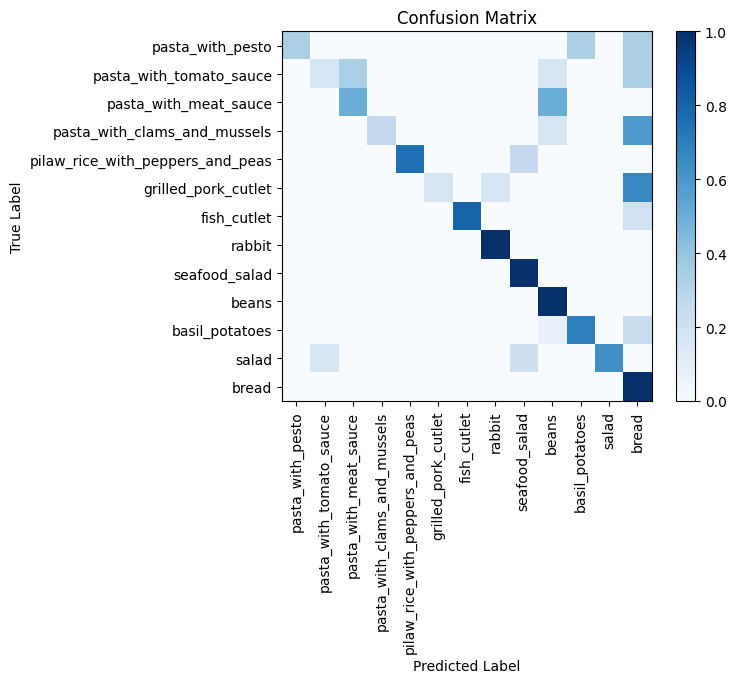

-Loaded model ./iter7.pt
---Accuracy: 0.7946428571428571 , avg_pos: 1.5536904391155404
------pasta_with_meat_sauce --> 3.5
------pasta_with_tomato_sauce --> 3.1666666666666665
------grilled_pork_cutlet --> 1.8333333333333333
------salad --> 1.4210526315789473
------pasta_with_clams_and_mussels --> 1.4166666666666667
------pasta_with_pesto --> 1.3333333333333333
------pilaw_rice_with_peppers_and_peas --> 1.25
------fish_cutlet --> 1.2
------basil_potatoes --> 1.0769230769230769
------rabbit --> 1.0
------seafood_salad --> 1.0
------beans --> 1.0
------bread --> 1.0


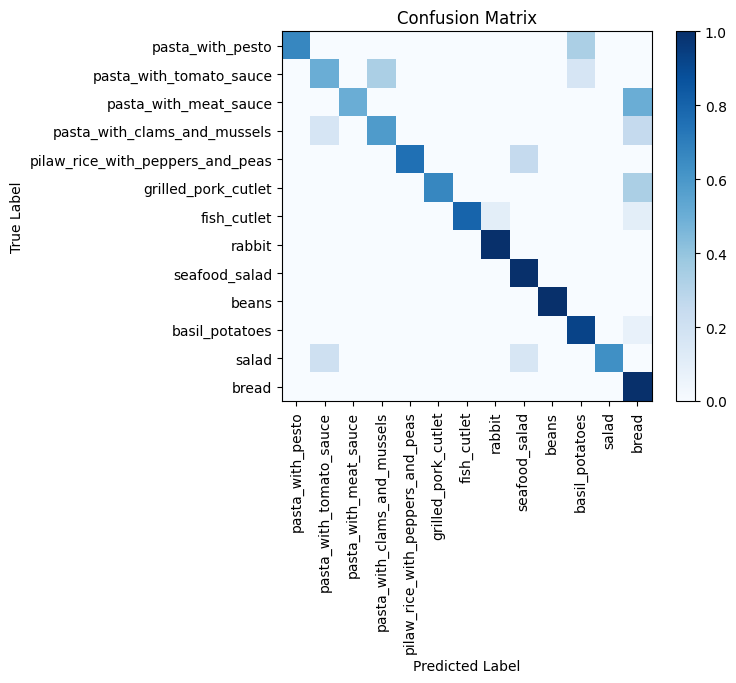

-Loaded model ./iter5.pt
---Accuracy: 0.7232142857142857 , avg_pos: 2.038417419287865
------pasta_with_tomato_sauce --> 4.0
------pasta_with_meat_sauce --> 4.0
------grilled_pork_cutlet --> 4.0
------basil_potatoes --> 2.5384615384615383
------pasta_with_clams_and_mussels --> 2.3333333333333335
------pasta_with_pesto --> 2.0
------pilaw_rice_with_peppers_and_peas --> 1.25
------fish_cutlet --> 1.2
------rabbit --> 1.125
------salad --> 1.0526315789473684
------seafood_salad --> 1.0
------beans --> 1.0
------bread --> 1.0


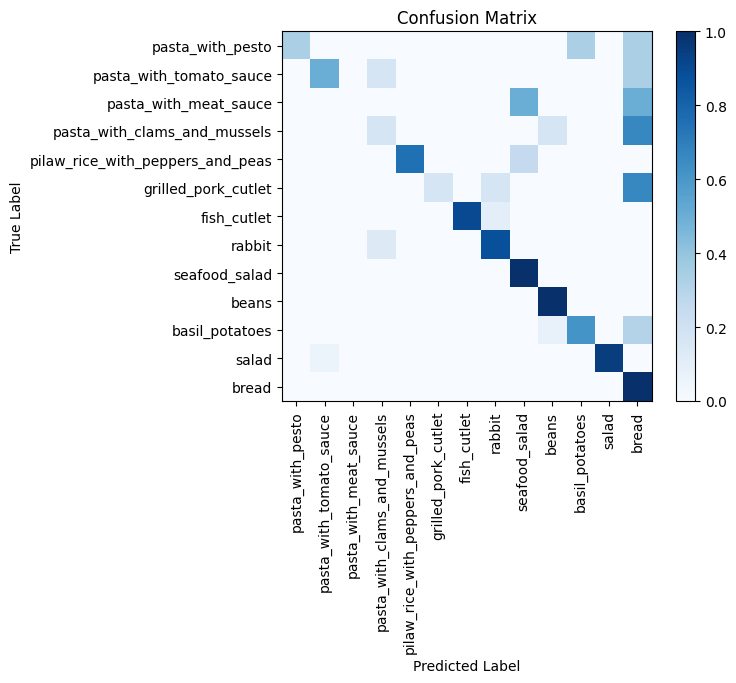

In [21]:
model_paths = glob.glob('./*.pt')

labelsDict = {
    "pasta_with_pesto": 0,
    "pasta_with_tomato_sauce": 1,
    "pasta_with_meat_sauce": 2,
    "pasta_with_clams_and_mussels": 3,
    "pilaw_rice_with_peppers_and_peas": 4,
    "grilled_pork_cutlet": 5,
    "fish_cutlet": 6,
    "rabbit": 7,
    "seafood_salad": 8,
    "beans": 9,
    "basil_potatoes": 10,
    "salad": 11,
    "bread": 12
  }
labels_map = {value: key for key, value in labelsDict.items()}

for model in model_paths:
  # Load the model
  try:
    myNet.load_state_dict(torch.load(model))
  except:
    continue
  print(f"-Loaded model {model}")
  # Compute accuracy
  accuracy = test(myNet, test_dataloader)
  if VERBOSE:
    avg_pos, avg_index  = avg_position(myNet, test_dataloader, return_dict=True)
  else:
    avg_pos = avg_position(myNet, test_dataloader, return_dict=False)
  print(f"---Accuracy: {accuracy} , avg_pos: {avg_pos}")

  if VERBOSE:
    sorted_list = sorted(avg_index.items(), key=lambda x: x[1], reverse=True)
    for el in sorted_list:
      print(f"------{labels_map[el[0]]} --> {el[1]}")
    class_names = labelsDict.keys()
    confusion_matrix = calculate_confusion_matrix(myNet, test_dataloader, len(class_names))
    plot_confusion_matrix(confusion_matrix, class_names)

## Exporting for LibTorch (C++)

The last bit of code is useful only to export the current model (name chosen in the topmost code cell) to a jit traced model to use it in c++ with the LibTorch library.

In [ ]:
EXPORT_JIT = True # @param {type: "boolean"}

In [ ]:
if True:
  # Exporting jit, REMEBER THE map_location OPTION!
  exportNet = Net('cpu')
  exportNet.load_state_dict(torch.load(model_name,  map_location=torch.device("cpu")))


  # Use torch.jit.trace to generate a torch.jit.ScriptModule via tracing.
  exportNet.eval()
  example = torch.ones(1, 3, 224, 224)
  export_name = model_name + "h"
  traced_script_module = torch.jit.trace(exportNet, example)
  traced_script_module.save(export_name)
  colab_files.download(export_name)

  # Printing the example output to compare it with the C++ output
  print(exportNet(example))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tensor([0.0089, 0.0131, 0.0075, 0.0067, 0.0052, 0.0051, 0.1653, 0.0036, 0.0027,
        0.7464, 0.0058, 0.0050, 0.0247], grad_fn=<SoftmaxBackward0>)
